In [1]:
import uproot
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import yahist
import itertools

plt.rcParams.update({"figure.facecolor":  (1,1,1,0)})

from utils.analysis import Optimization

TAG = "pku"

In [2]:
presort_babies = sorted(glob.glob(f"../analysis/studies/vbswh/output_{TAG}/Run2/*.root"))
presort_babies = [baby for baby in presort_babies if "data" not in baby]
babies = []
for baby in sorted(presort_babies, reverse=True):
    if "EWK" in baby.split("/")[-1]:
        babies.append(baby)
    else:
        babies.insert(0, baby)
        
for baby_i, baby in enumerate(babies):
    if "VBSWH_SM" in baby.split("/")[-1] in baby:
        babies.append(babies.pop(baby_i))
        break
babies

['../analysis/studies/vbswh/output_pku/Run2/Bosons.root',
 '../analysis/studies/vbswh/output_pku/Run2/SingleTop.root',
 '../analysis/studies/vbswh/output_pku/Run2/TTX.root',
 '../analysis/studies/vbswh/output_pku/Run2/TTbar1L.root',
 '../analysis/studies/vbswh/output_pku/Run2/TTbar2L.root',
 '../analysis/studies/vbswh/output_pku/Run2/VBSWH_mkW.root',
 '../analysis/studies/vbswh/output_pku/Run2/VH.root',
 '../analysis/studies/vbswh/output_pku/Run2/WJets.root',
 '../analysis/studies/vbswh/output_pku/Run2/EWKWLep.root',
 '../analysis/studies/vbswh/output_pku/Run2/VBSWH_SM.root']

In [3]:
vbswh = Optimization(
    sig_root_files=[baby for baby in babies if "VBSWH_mkW" in baby],
    bkg_root_files=[baby for baby in babies if "VBSWH_mkW" not in baby],
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", "lep_id_sf", "ewkfix_sf", 
        "elec_reco_sf", "muon_iso_sf", 
        "btag_sf", "pu_sf", "prefire_sf", "trig_sf"
    ],
    plots_dir=f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt",
    sample_labels = {
        "VBSWH_SM": "VBSWH (SM)", 
        "TTbar1L": r"$t\bar{t}+1\ell$",
        "TTbar2L": r"$t\bar{t}+2\ell$",
        "TTX": r"$t\bar{t}+X$",
        "SingleTop": "Single top",
        "WJets": "W+jets",
        "EWKWLep": r"EWK W$\rightarrow\ell\nu$"
    },
    vector_branches=["reweights"]
)
vbswh.df["presel_noVBS_noBVeto"] = vbswh.df.eval(
    "hbbjet_score > 0.3"
)
vbswh.df["presel_noVBS"] = vbswh.df.eval(
    "passes_bveto and hbbjet_score > 0.3"
)
vbswh.df["presel_noDetaJJ"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and hbbjet_score > 0.3"
)
vbswh.df["presel"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and abs(deta_jj) > 3 and hbbjet_score > 0.3"
)
# vbswh.df["SR"] = vbswh.df.eval(
#     "presel and ST > 1200 and M_jj > 1500 and abs(deta_jj) > 4 and hbbjet_score > 0.9 and hbbjet_msoftdrop < 150"
# )
vbswh.df["SR2"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 1500 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150"
)
vbswh.df["regionA"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionB"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) <= 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionC"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) <= 4 and hbbjet_msoftdrop < 150"
)
vbswh.df["SR1"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150"
)
# vbswh.make_selection("passes_bveto == True")
# vbswh.make_selection("passes_bveto != True")

Loading bkg babies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  3.77s/it]


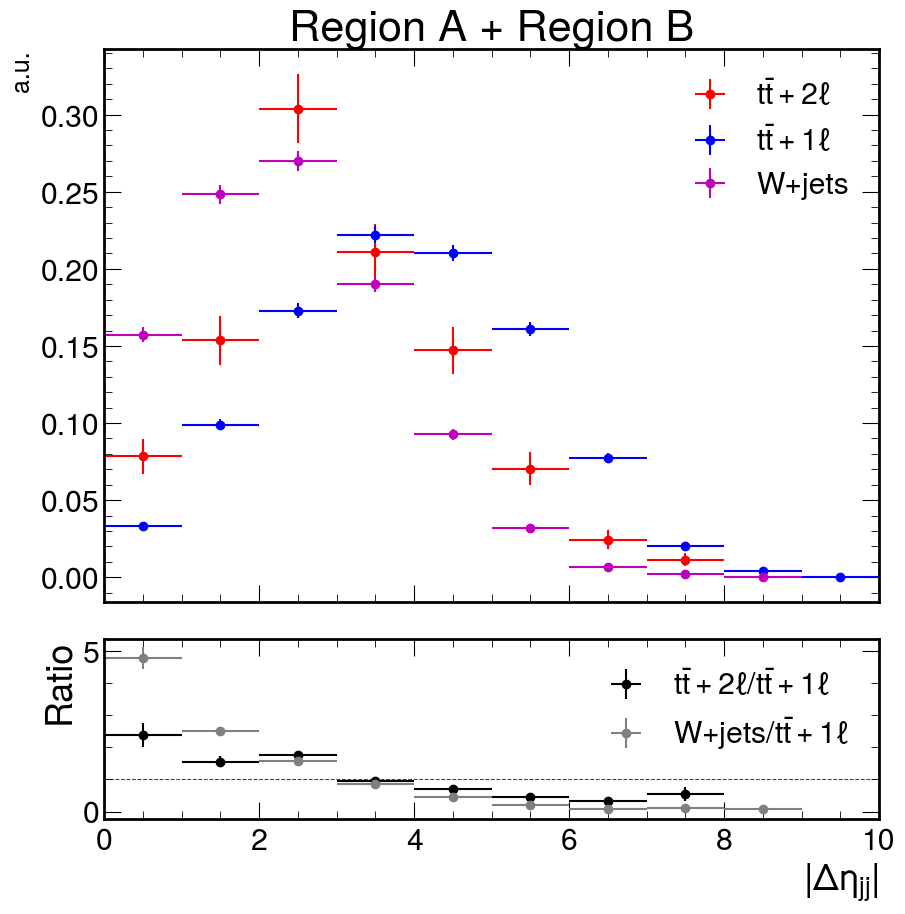

In [4]:
selection = "(regionA or regionB)"
bins = np.linspace(0, 10, 11)

fig = plt.figure()
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.1)
hist_axes = fig.add_subplot(gs[0])
ratio_axes = fig.add_subplot(gs[1])


tt1l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar1L'")
tt2l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar2L'")
wjets_df = vbswh.bkg_df(selection=f"{selection} and name == 'WJets'")

tt1l_hist = yahist.Hist1D(
    np.abs(tt1l_df.deta_jj.values),
    bins=bins,
    color="b",
    label=r"$t\bar{t}+1\ell$"
).normalize()
tt2l_hist = yahist.Hist1D(
    np.abs(tt2l_df.deta_jj.values),
    bins=bins,
    color="r",
    label=r"$t\bar{t}+2\ell$"
).normalize()
wjets_hist = yahist.Hist1D(
    np.abs(wjets_df.deta_jj.values),
    bins=bins,
    color="m",
    label="W+jets"
).normalize()
ratio_hist = tt1l_hist/tt2l_hist

tt2l_hist.plot(ax=hist_axes, errors=True)
tt1l_hist.plot(ax=hist_axes, errors=True)
wjets_hist.plot(ax=hist_axes, errors=True)
(tt2l_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="k", label=r"$t\bar{t}+2\ell/t\bar{t}+1\ell$")
(wjets_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="grey", label=r"W+jets$/t\bar{t}+1\ell$")

hist_axes.set_xticklabels([]);
hist_axes.set_ylabel("a.u.", size=18)
hist_axes.set_title("Region A + Region B");

ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
# ratio_axes.legend().remove()
ratio_axes.set_ylabel("Ratio");
ratio_axes.set_xlabel(r"$|\Delta\eta_{jj}|$");

plot_file = f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt/AB_wjets_vs_ttbar.pdf"
plt.savefig(plot_file, bbox_inches="tight")

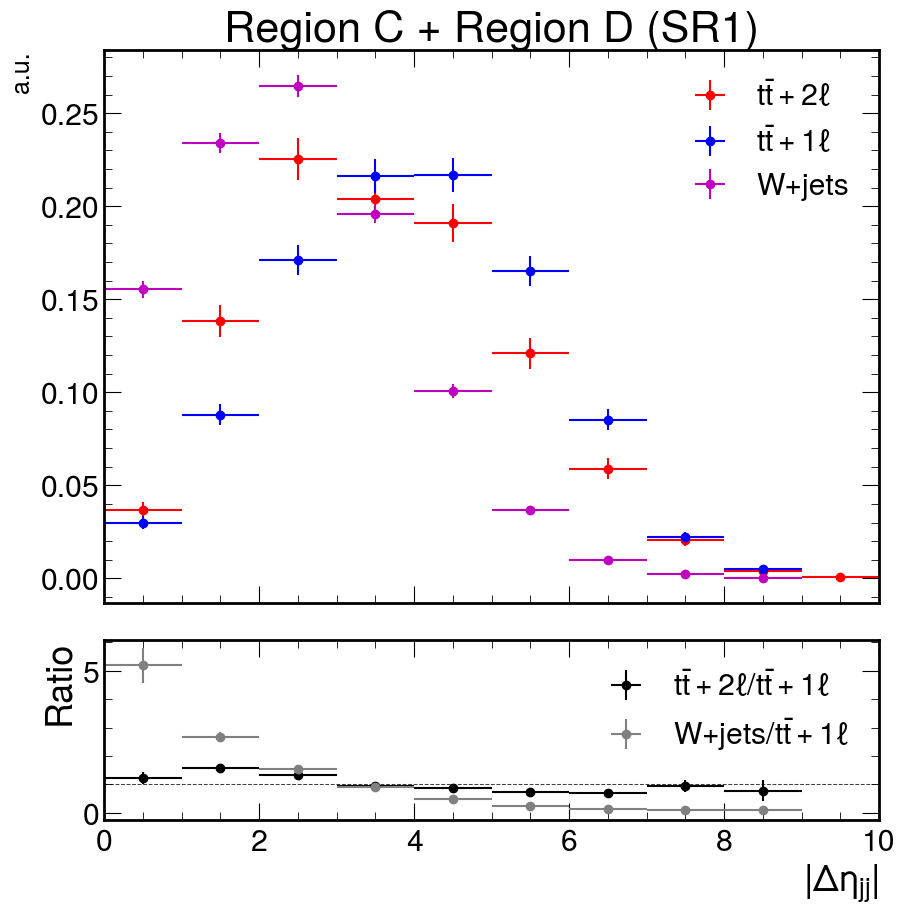

In [5]:
selection = "(regionC or SR1)"
bins = np.linspace(0, 10, 11)

fig = plt.figure()
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.1)
hist_axes = fig.add_subplot(gs[0])
ratio_axes = fig.add_subplot(gs[1])


tt1l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar1L'")
tt2l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar2L'")
wjets_df = vbswh.bkg_df(selection=f"{selection} and name == 'WJets'")

tt1l_hist = yahist.Hist1D(
    np.abs(tt1l_df.deta_jj.values),
    bins=bins,
    color="b",
    label=r"$t\bar{t}+1\ell$"
).normalize()
tt2l_hist = yahist.Hist1D(
    np.abs(tt2l_df.deta_jj.values),
    bins=bins,
    color="r",
    label=r"$t\bar{t}+2\ell$"
).normalize()
wjets_hist = yahist.Hist1D(
    np.abs(wjets_df.deta_jj.values),
    bins=bins,
    color="m",
    label="W+jets"
).normalize()
ratio_hist = tt1l_hist/tt2l_hist

tt2l_hist.plot(ax=hist_axes, errors=True)
tt1l_hist.plot(ax=hist_axes, errors=True)
wjets_hist.plot(ax=hist_axes, errors=True)
(tt2l_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="k", label=r"$t\bar{t}+2\ell/t\bar{t}+1\ell$")
(wjets_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="grey", label=r"W+jets$/t\bar{t}+1\ell$")

hist_axes.set_xticklabels([]);
hist_axes.set_ylabel("a.u.", size=18)
hist_axes.set_title("Region C + Region D (SR1)");

ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
# ratio_axes.legend().remove()
ratio_axes.set_ylabel("Ratio");
ratio_axes.set_xlabel(r"$|\Delta\eta_{jj}|$");

plot_file = f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt/CD_wjets_vs_ttbar.pdf"
plt.savefig(plot_file, bbox_inches="tight")

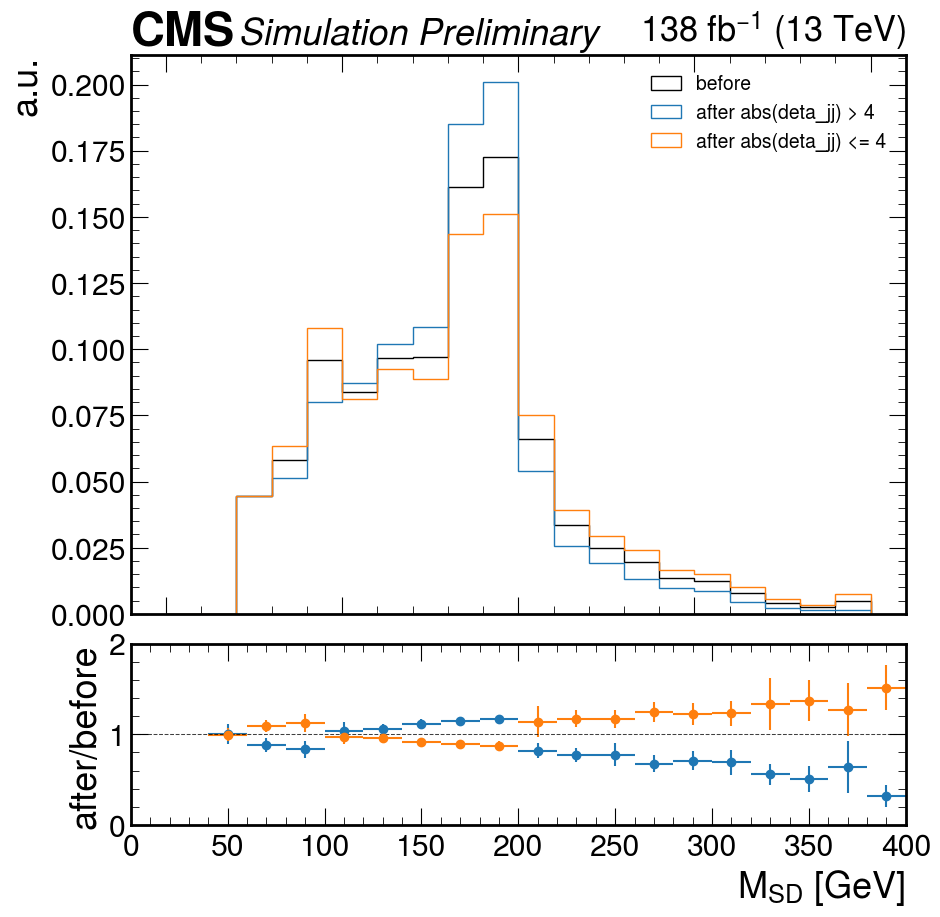

In [6]:
vbswh.plot_correlation(
    "hbbjet_msoftdrop", 
    np.linspace(0, 400, 21), 
    selections=[
        "abs(deta_jj) > 4",
        "abs(deta_jj) <= 4"
    ],
    base_selection="presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9",
    x_label="$M_{SD}$ [GeV]",
);

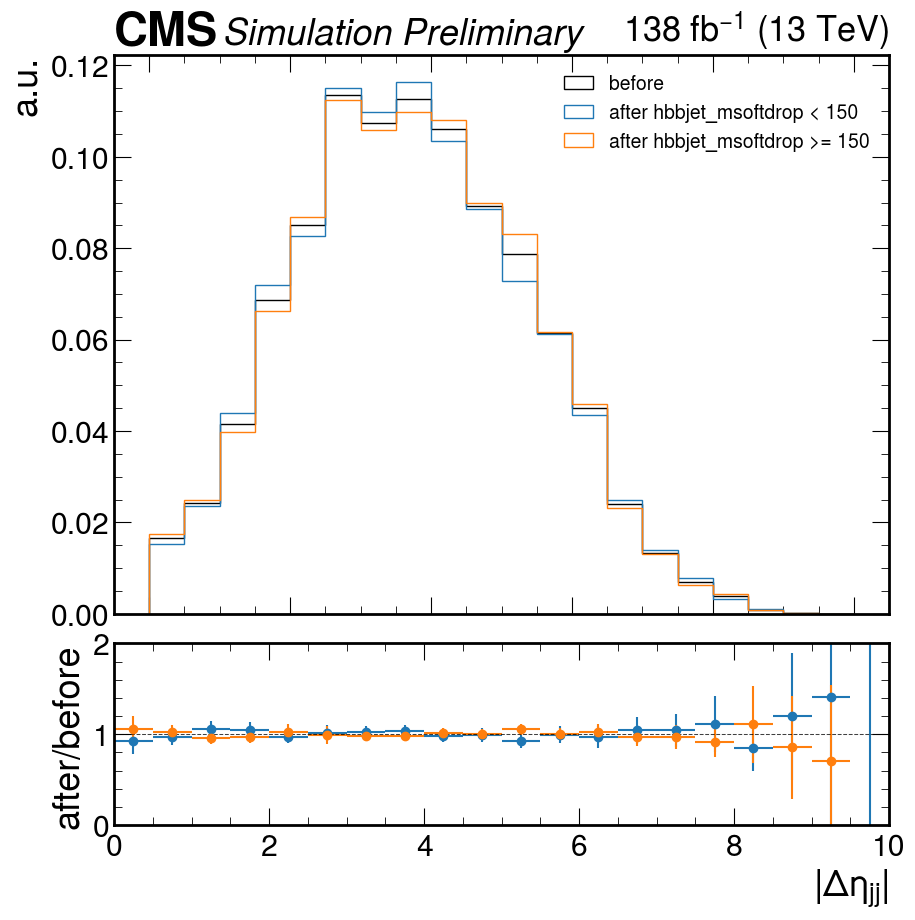

In [7]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 21),  
    selections=[
        "hbbjet_msoftdrop < 150",
        "hbbjet_msoftdrop >= 150"
    ], 
    base_selection="presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

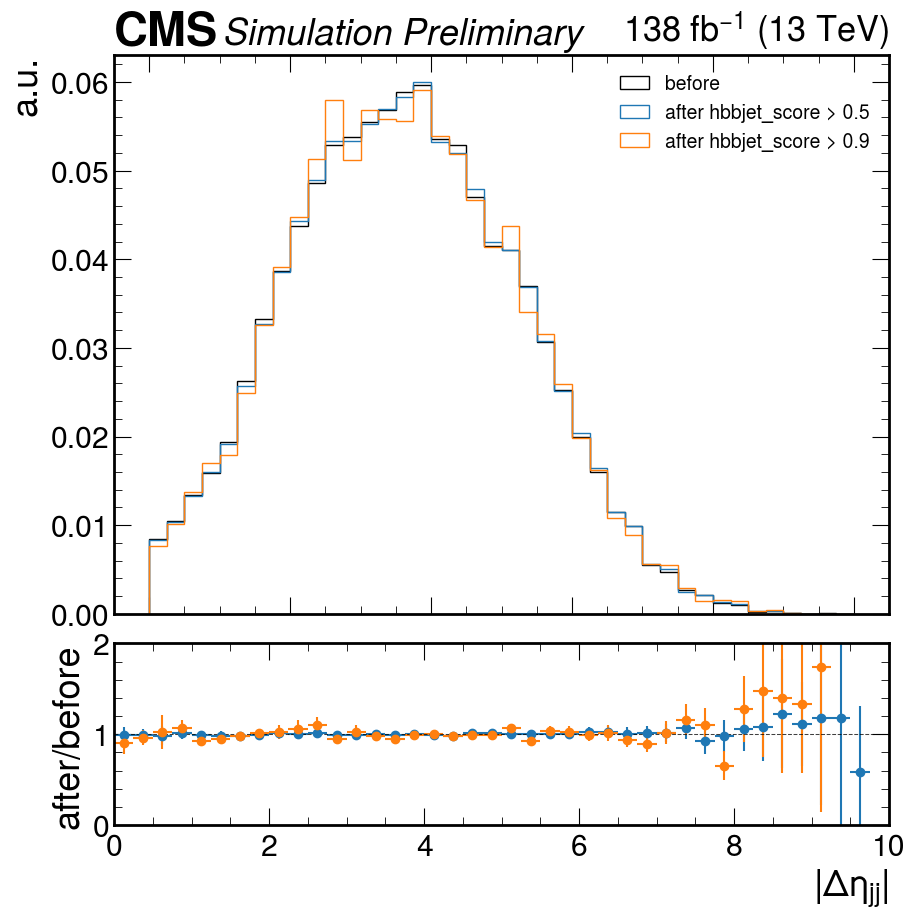

In [8]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 41),  
    selections=[
        "hbbjet_score > 0.5",
        "hbbjet_score > 0.9"
    ], 
    base_selection="presel_noDetaJJ and hbbjet_msoftdrop >= 150",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

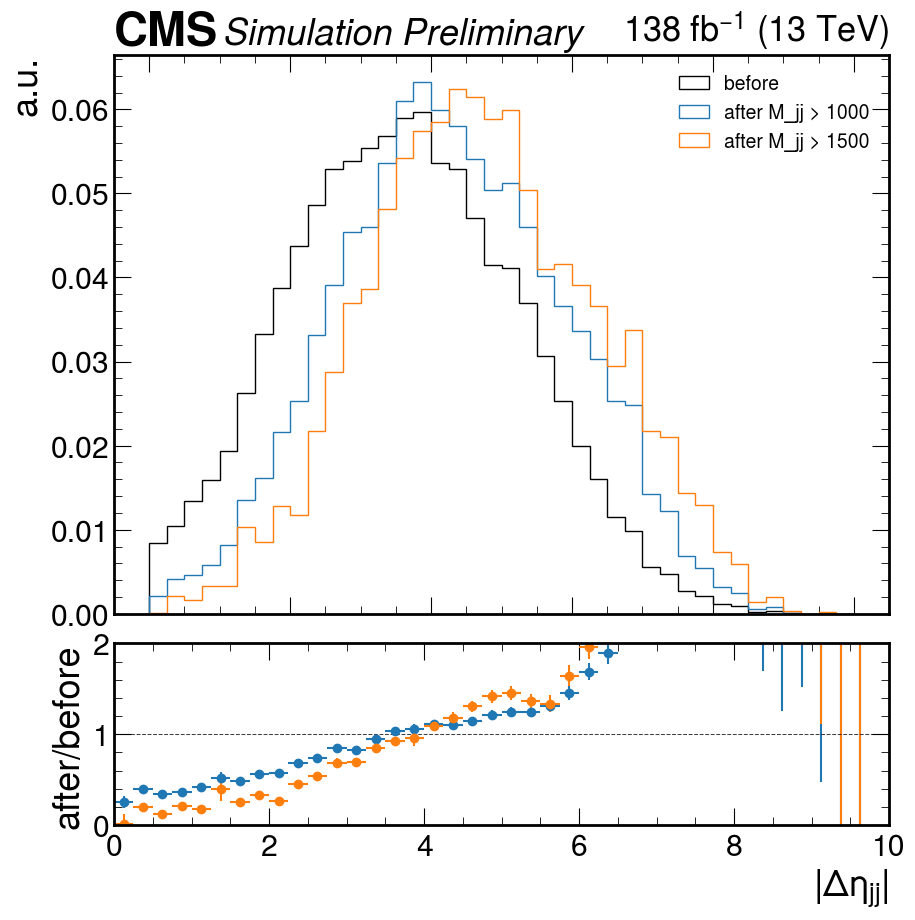

In [9]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 41),  
    selections=[
        "M_jj > 1000",
        "M_jj > 1500"
    ], 
    base_selection="presel_noDetaJJ and hbbjet_msoftdrop >= 150",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

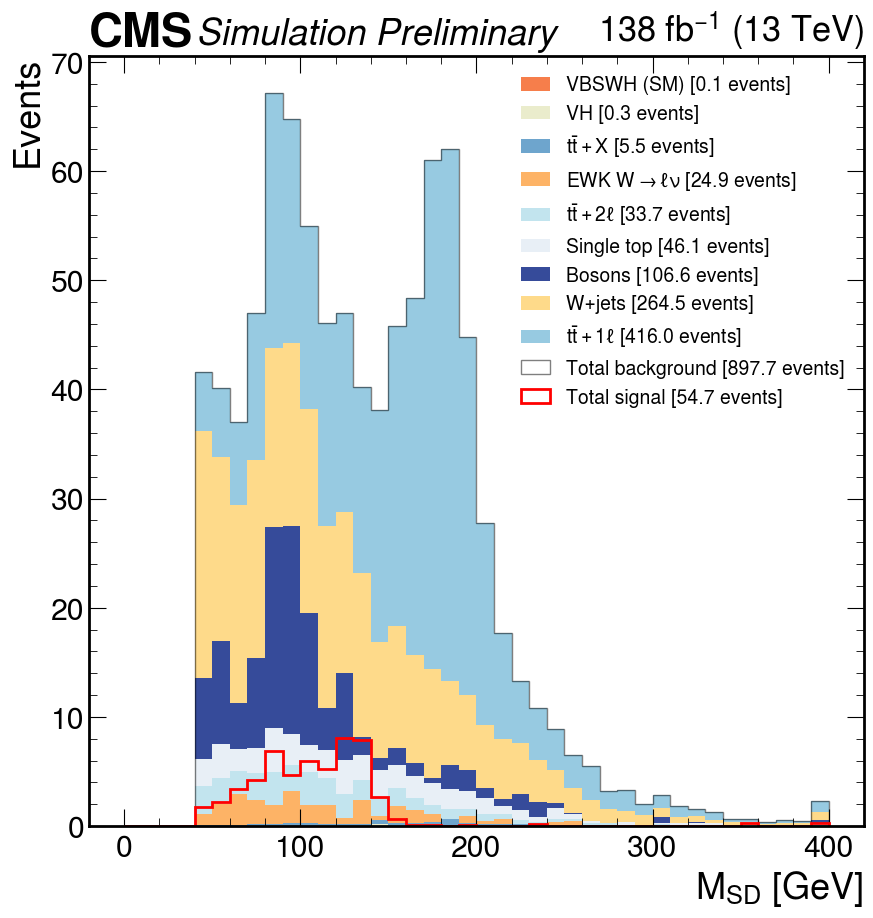

In [10]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_msoftdrop", np.linspace(0, 400, 41), 
    selection="presel and hbbjet_score < 0.6",
    x_label="$M_{SD}$ [GeV]",
    stacked=True,
#     norm=True
);

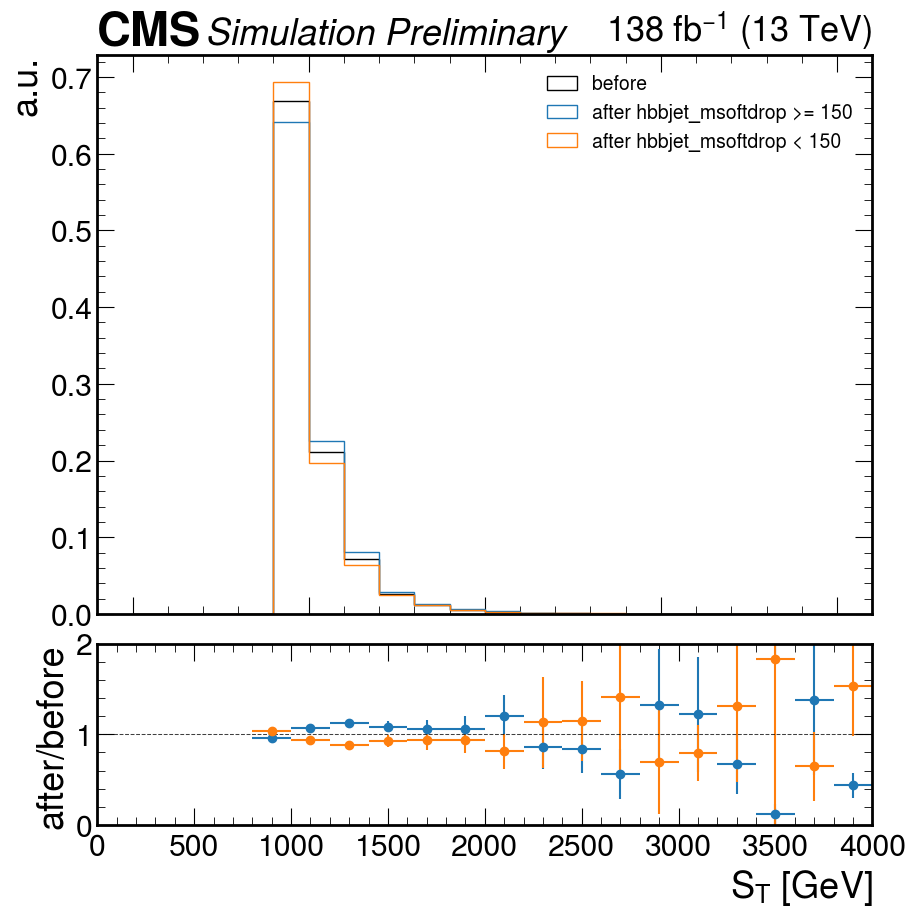

In [11]:
vbswh.plot_correlation(
    "ST", 
    np.linspace(0, 4000, 21),  
    selections=[
        "hbbjet_msoftdrop >= 150",
        "hbbjet_msoftdrop < 150"
    ], 
    base_selection="presel",
    x_label=r"$S_T$ [GeV]"
);

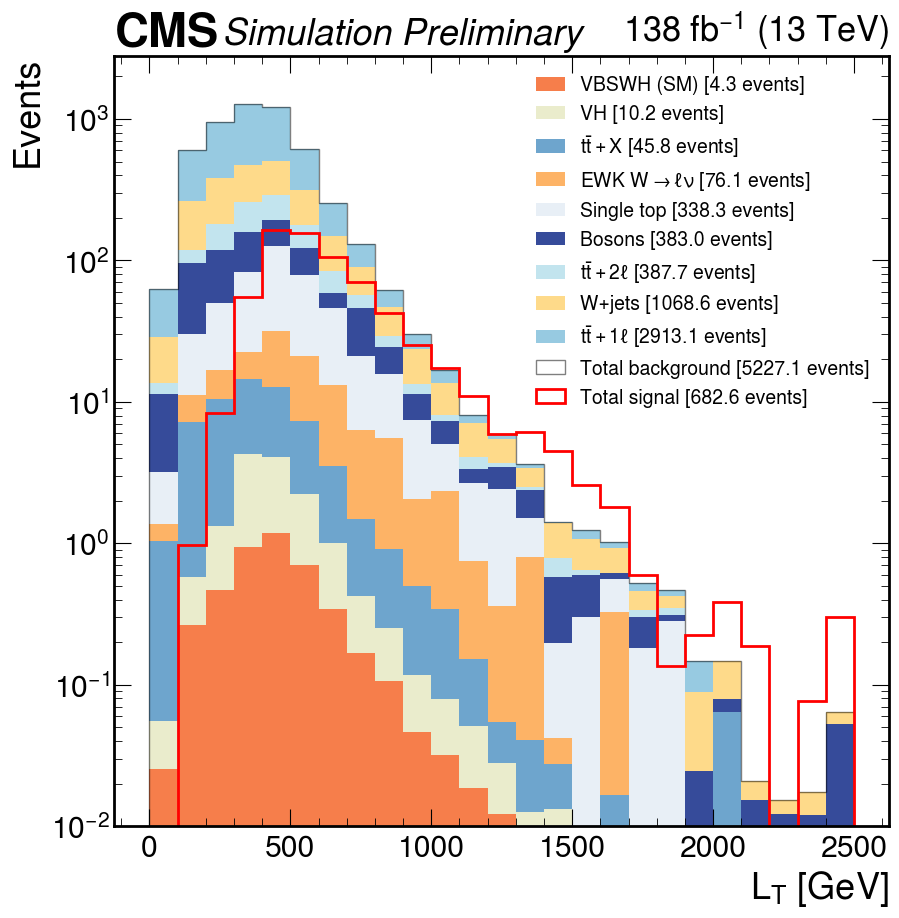

In [12]:
axes = vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 2500, 26), 
    selection="presel_noDetaJJ",
    x_label="$L_T$ [GeV]",
    stacked=True,
    logy=True
);

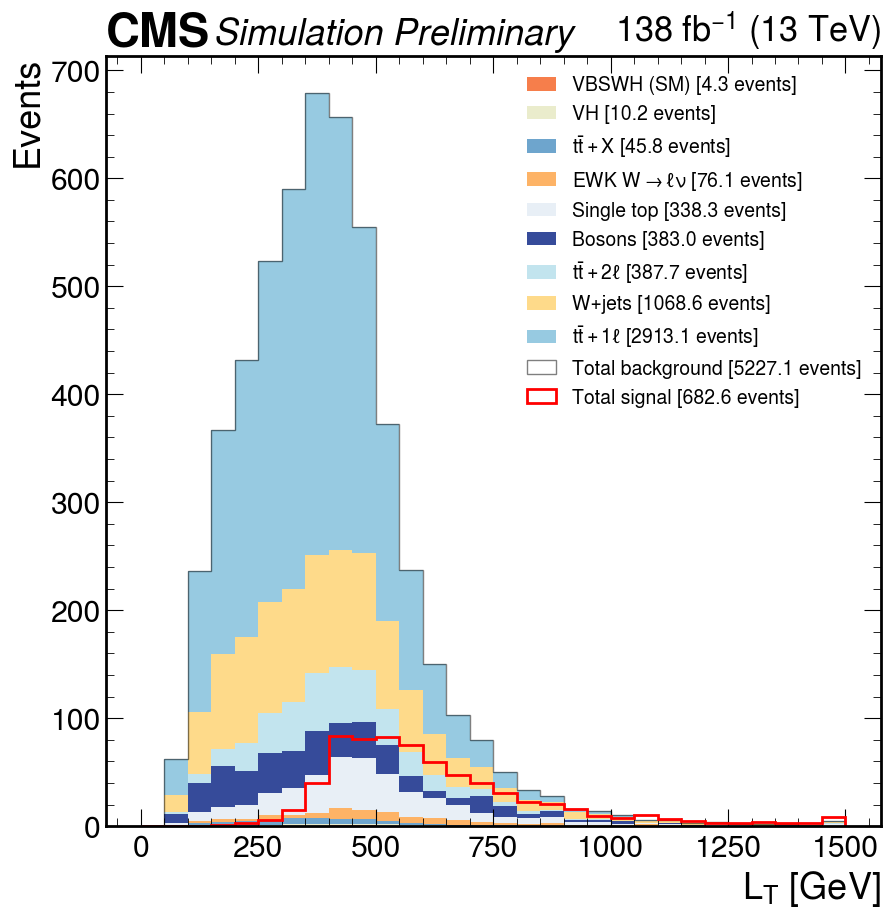

In [13]:
axes = vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 1500, 31), 
    selection="presel_noDetaJJ",
    x_label="$L_T$ [GeV]",
    stacked=True,
#     norm=True
);

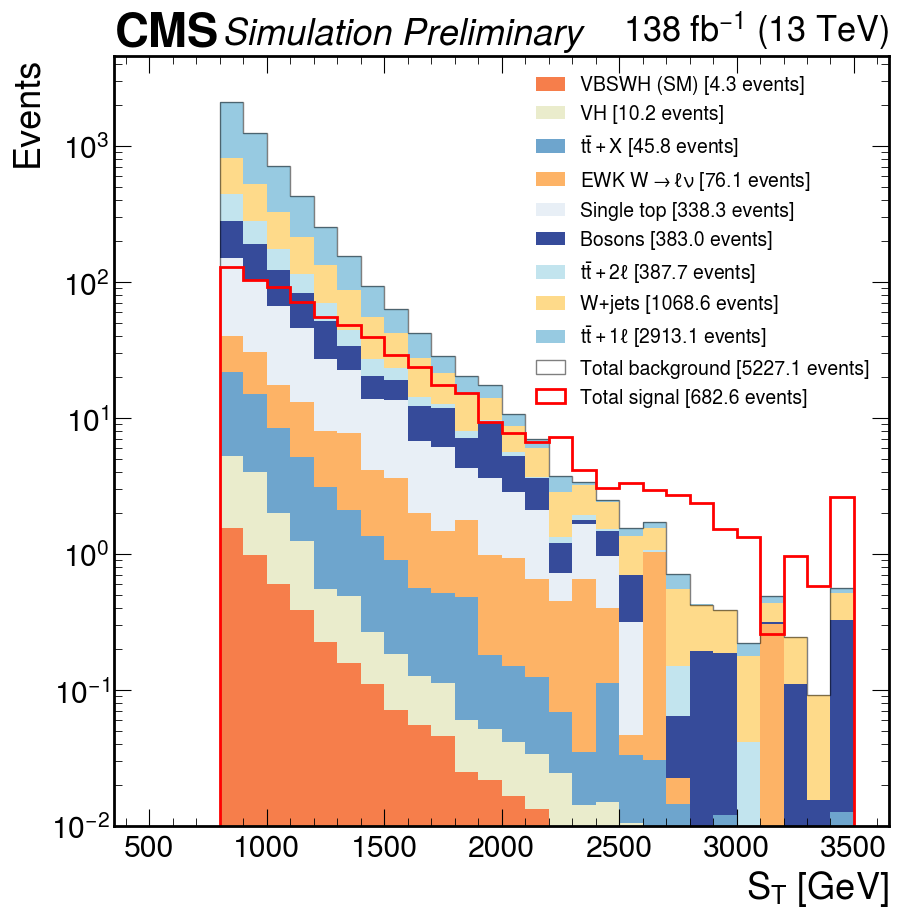

In [14]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(500, 3500, 31), 
    selection="presel_noDetaJJ",
    x_label="$S_T$ [GeV]",
    stacked=True,
    logy=True
);

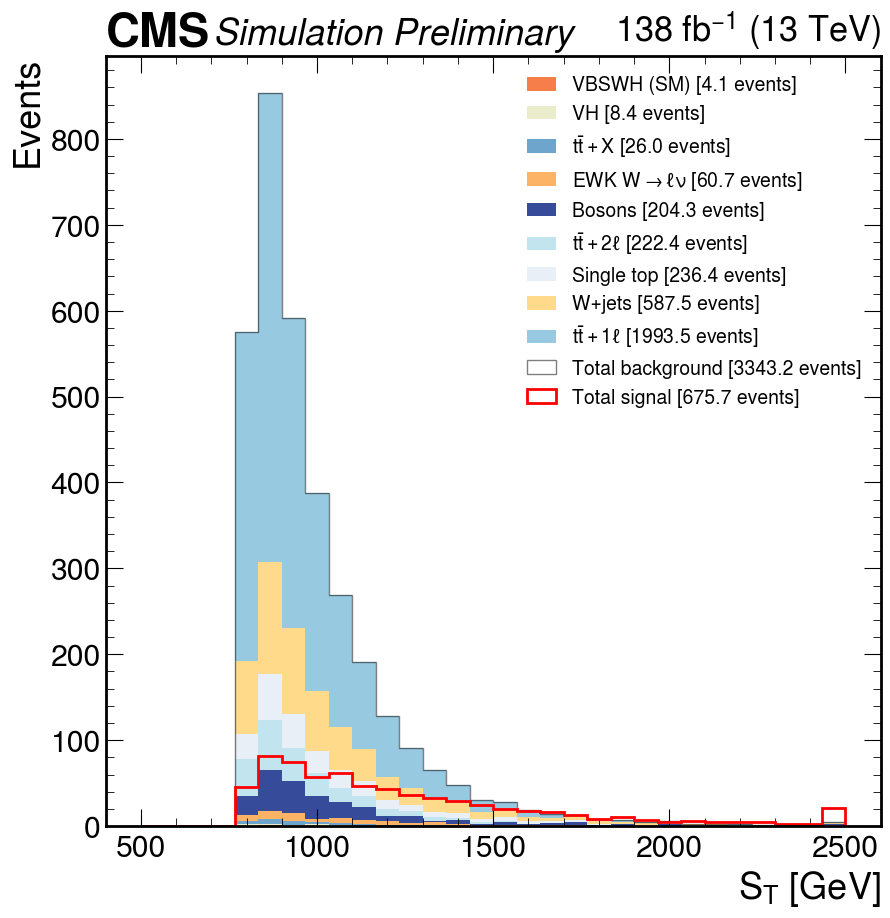

In [15]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(500, 2500, 31), 
    selection="presel",
    x_label="$S_T$ [GeV]",
    stacked=True,
#     logy=True,
#     norm=True
);

In [16]:
vbswh.get_event_counts(selection="presel and hbbjet_msoftdrop >= 150")

(20.51263576437909, 1624.1364716586097)

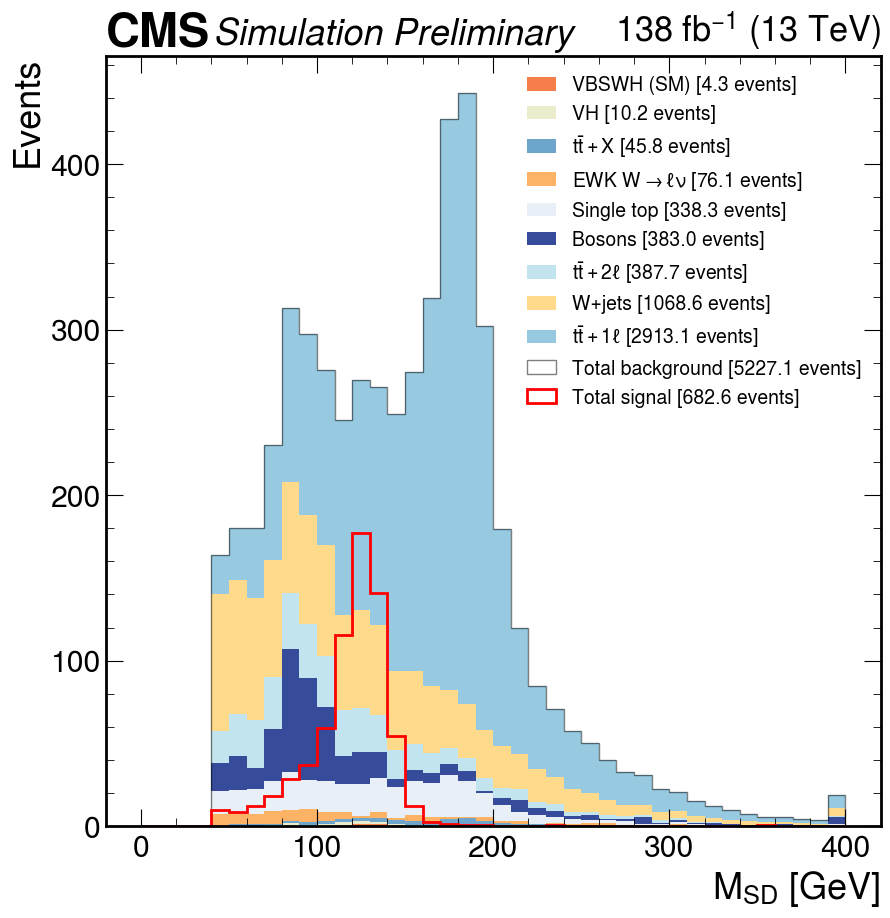

In [17]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_msoftdrop", np.linspace(0, 400, 41), 
    selection="presel_noDetaJJ",
    x_label="$M_{SD}$ [GeV]",
    stacked=True,
#     norm=True
);

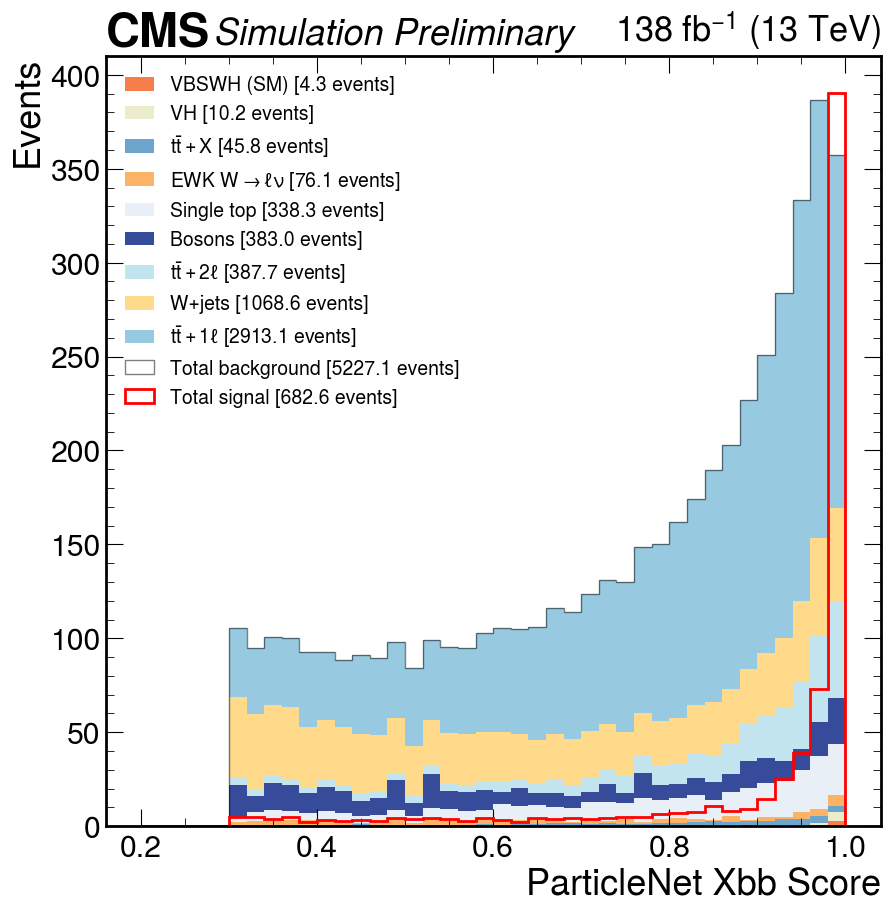

In [18]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_score", np.linspace(0.2, 1, 41), 
    selection="presel_noDetaJJ",
    x_label="ParticleNet Xbb Score",
    stacked=True,
    legend_loc="upper left"
#     norm=True
);

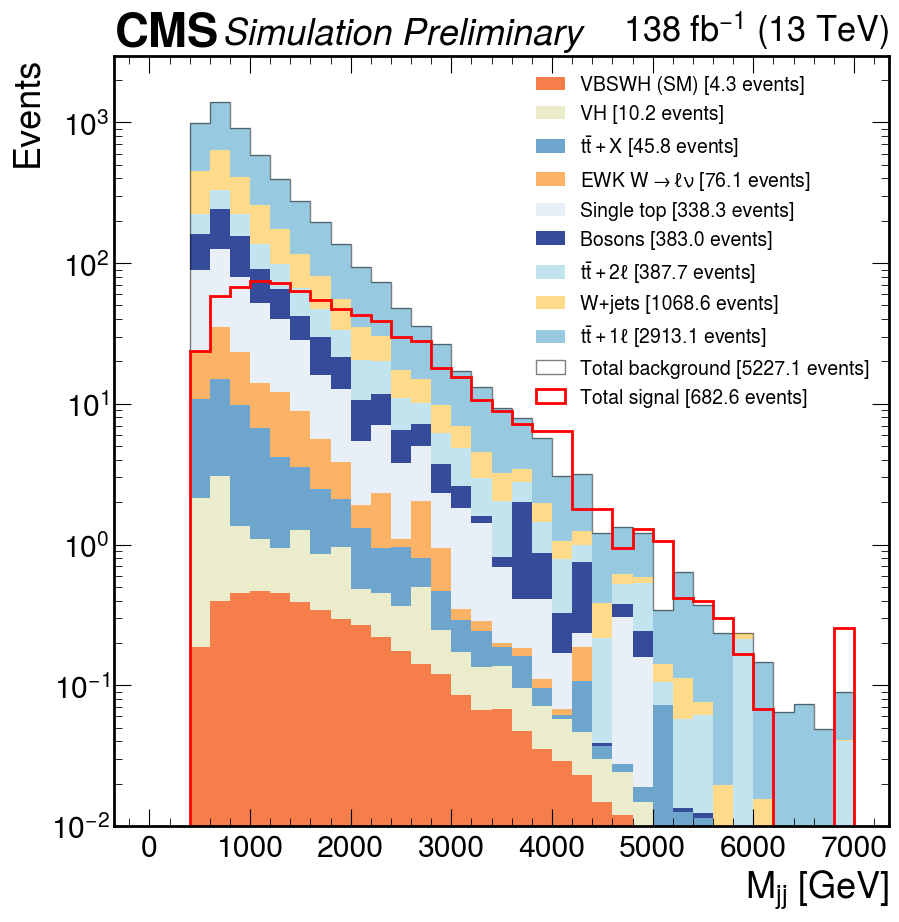

In [19]:
axes = vbswh.plot_sig_vs_bkg(
    "M_jj", np.linspace(0, 7000, 36), 
    selection="presel_noDetaJJ",
    x_label="$M_{jj}$ [GeV]",
    stacked=True,
    logy=True
);

In [20]:
vbswh.get_event_counts(selection="presel_noDetaJJ and abs(deta_jj) <= 3")

(6.883198309624815, 1883.859198473163)

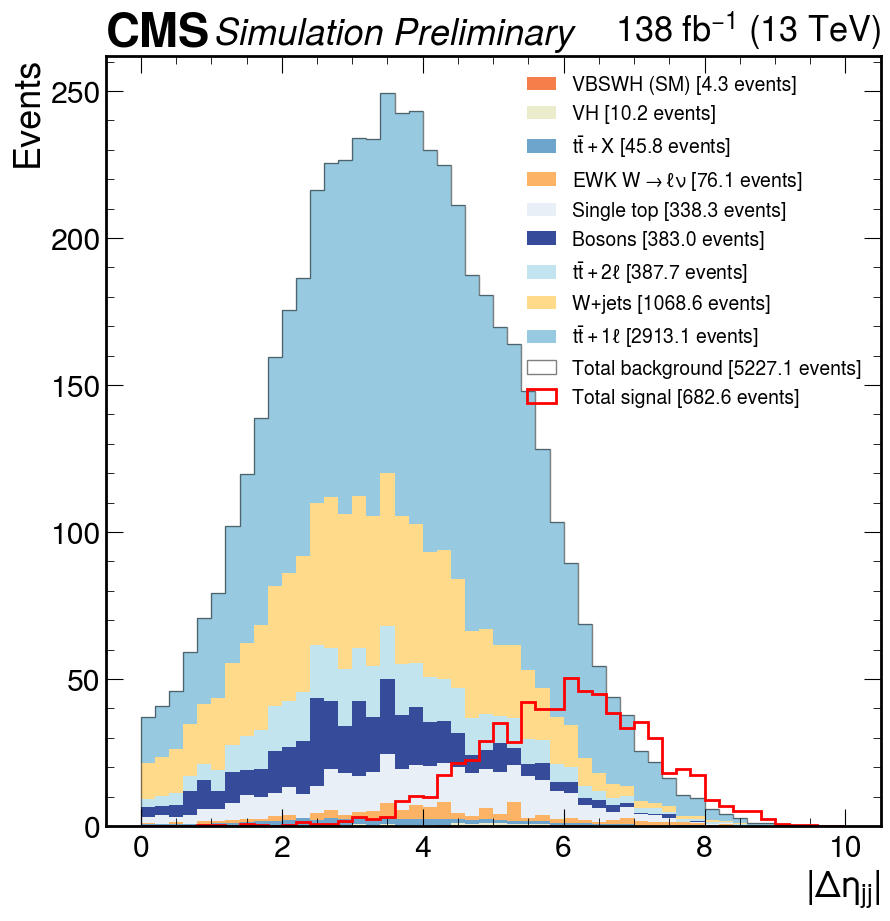

In [21]:
axes = vbswh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 51), 
    selection="presel_noDetaJJ", 
    x_label="$|\Delta\eta_{jj}|$",
    transf=abs,
    stacked=True
);

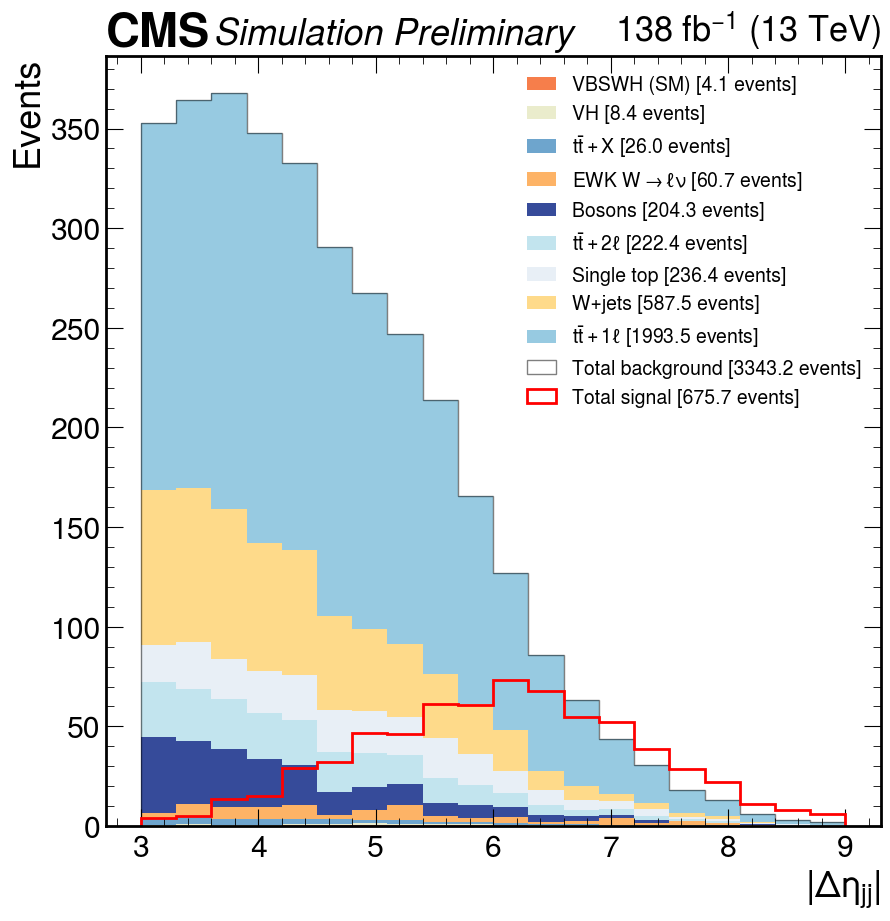

In [22]:
axes = vbswh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(3, 9, 21), 
    selection="presel", 
    x_label="$|\Delta\eta_{jj}|$",
    transf=abs,
    stacked=True
);

In [23]:
vbswh.fom_scan(
    "deta_jj", [3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7], operator=">", 
    base_selection="M_jj > 1500", abs=True
)

sel,sig,bkg,fom
M_jj > 1500,568.096591335536,5488.959614962511,7.667912805453939
M_jj > 1500 and abs(deta_jj) > 3.5,565.998692001688,4308.314881976318,8.623065977294024
M_jj > 1500 and abs(deta_jj) > 4,561.2999300780745,3782.4511430462367,9.126585455061008
M_jj > 1500 and abs(deta_jj) > 4.5,554.5173881662279,3157.1155441933265,9.868926868637278
M_jj > 1500 and abs(deta_jj) > 5,533.5117627088722,2457.256425102321,10.762638652412479
M_jj > 1500 and abs(deta_jj) > 5.5,500.963832506575,1808.325791527032,11.780616935650286
M_jj > 1500 and abs(deta_jj) > 6,435.33321597272385,1268.1924363281364,12.224447108092953
M_jj > 1500 and abs(deta_jj) > 6.5,327.54197121558695,853.2739494287177,11.213023052082873
M_jj > 1500 and abs(deta_jj) > 7,222.60609857366254,517.854026435639,9.782128861155467


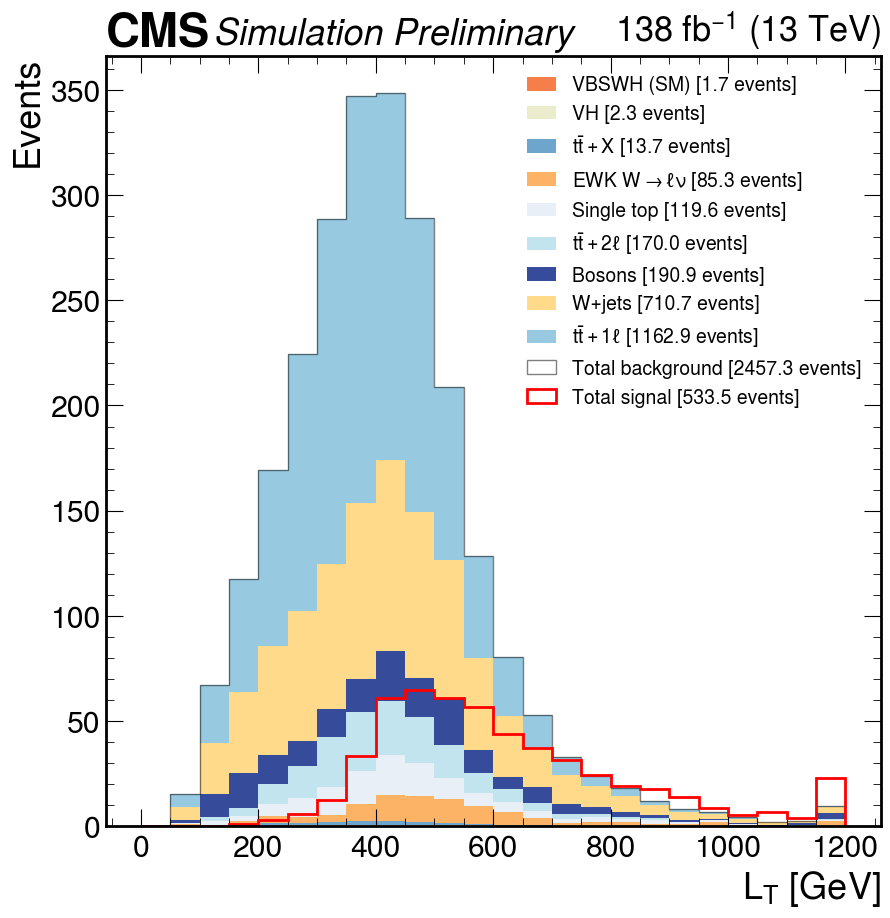

In [24]:
vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 1200, 25), 
    selection="M_jj > 1500 and abs(deta_jj) > 5", 
    x_label="$L_T$ [GeV]",
    stacked=True
);

In [25]:
vbswh.fom_scan(
    "LT", [500, 600, 700, 800, 900, 1000, 1100, 1200], operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5"
);

sel,sig,bkg,fom
M_jj > 1500 and abs(deta_jj) > 5,533.5117627088722,2457.256425102321,10.762638652412479
M_jj > 1500 and abs(deta_jj) > 5 and LT > 500,352.56196844129084,590.06422975873,14.513956537257638
M_jj > 1500 and abs(deta_jj) > 5 and LT > 600,234.7324367774424,252.89448147742485,14.760580273828502
M_jj > 1500 and abs(deta_jj) > 5 and LT > 700,154.04226100340253,119.50873807960672,14.090942872413773
M_jj > 1500 and abs(deta_jj) > 5 and LT > 800,98.26964324241183,62.58332662274455,12.421958019602874
M_jj > 1500 and abs(deta_jj) > 5 and LT > 900,61.59873876183108,32.85156996767542,10.74716101194019
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1000,39.07996428136239,18.173542910854835,9.16715042333771
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1100,26.937218696229486,12.054127184231287,7.758626893875568
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1200,19.084643624319057,7.603452097132332,6.921156148866824


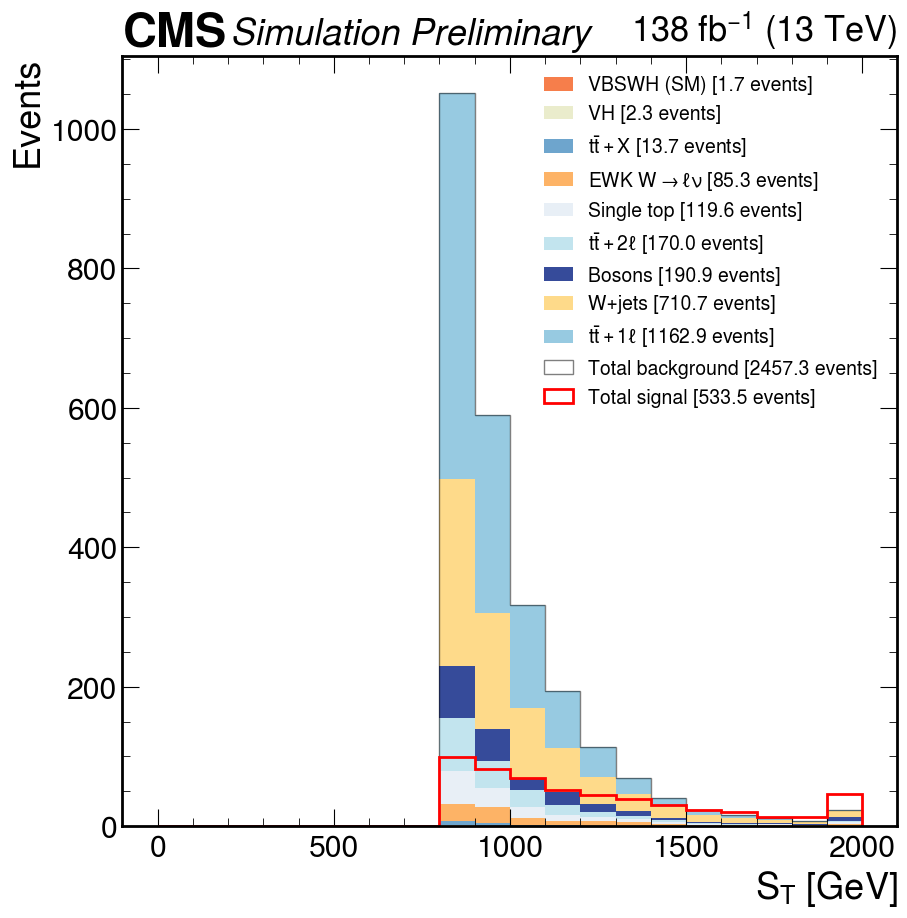

In [26]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(0, 2000, 21), 
    selection="M_jj > 1500 and abs(deta_jj) > 5", x_label="$S_T$ [GeV]",
    stacked=True
);

In [27]:
vbswh.fom_scan(
    "ST", [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1650, 1700, 1800], operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5"
)

sel,sig,bkg,fom
M_jj > 1500 and abs(deta_jj) > 5,533.5117627088722,2457.256425102321,10.762638652412479
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1000,352.050971201097,815.5306172693689,12.327795219854279
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1100,282.5838080497552,498.8700686700668,12.651835874257385
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1200,230.5151725848401,304.88326903220457,13.201786950936203
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300,185.853443678454,191.15942432424214,13.442274370925647
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1400,146.75450933781264,122.360178681053,13.266959503096487
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1500,116.91113827400908,82.33118999917293,12.884681648864962
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1600,93.88978080008573,59.289469723167436,12.193532554255343
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1650,83.72713096887526,50.617276514883045,11.768383778388573
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1700,73.58430001606276,42.915615077

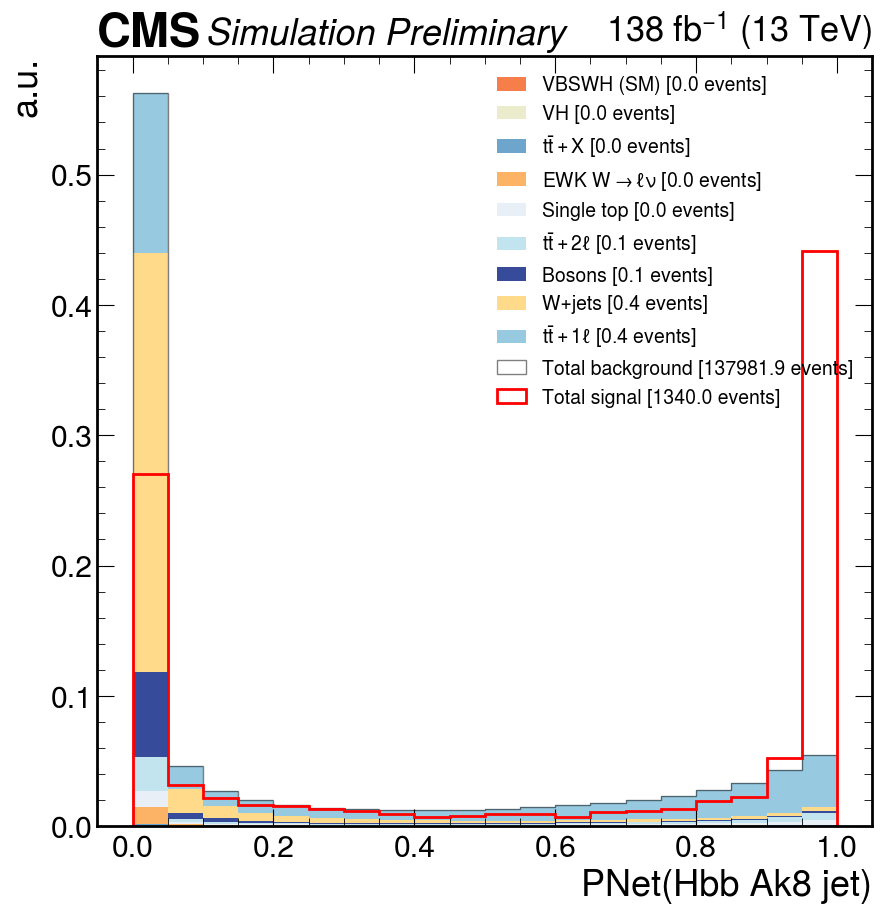

In [28]:
vbswh.plot_sig_vs_bkg(
    "hbbjet_score", np.linspace(0, 1.0, 21), 
#     selection="M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300", 
    x_label="PNet(Hbb Ak8 jet)",
    stacked=True,
    norm=True
);

In [29]:
vbswh.fom_scan(
    "hbbjet_score", np.linspace(0.91, 0.99, 9), operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300"
)

sel,sig,bkg,fom
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300,185.853443678454,191.15942432424214,13.442274370925647
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.91,97.29062772162008,15.646863354872652,24.595596550144585
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.92,96.0328735846073,14.068532723107788,25.603275056968865
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.93,93.9190262725072,12.725920589929673,26.32746092276756
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.9400000000000001,92.20745938764836,11.525183880594179,27.16077290792394
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.95,88.77359460443455,10.050177660198042,28.002508395886725
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.96,86.17173586136161,8.394685785594037,29.741482935643457
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.97,81.84731564977076,6.518605768781864,32.0